# Building a Corporate Valuation Model with Python Pt. II: DCF Method

Having established the database, I will build a corporate valuation model identical to the methods given in [Brigham & Houston ("Fundamentals of Financial Management", 6th ed., 2009, South Western Cengage Learning, pp. 288 and pp. 306)](https://www.valorebooks.com/textbooks/fundamentals-of-financial-management-concise-edition-with-thomson-one-business-school-edition-6th-edition/9780324664553). Additionally, one can check the [this source](https://corporatefinanceinstitute.com/resources/knowledge/modeling/dcf-model-training-free-guide/), too, for further insights on the topic of corporate valuation.

Before starting the analysis we need some general assumptions and information on data in order to implement the DCF method for company valuation. We need the _after-tax cost of debt_ for the specific company as well as the _cost of its equity_. As for the debt it is quite cumbersome to get the individual firm´s cost of debt - either we would need to check the annual reports of that company or be lucky and find a free platform that offers such an information for any possible company. Both methods are difficult to implement in a dynamic and automated manner within a python script; I would need to build an extra scraper just to retrieve such an information for any possible firm. And I barely believe that there is a free source for that.

<u><h4><font color="#ab4e52">Cost of Debt Estimate</font></h4></u>

Hence, I will **use the [central bank information on interest rates](https://sdw.ecb.europa.eu/browse.do?node=bbn2883) of new loans (>1 EURm) for non-financial corporations** and retrieve interest rate time series data from the `ECB SDM 2.1 RESTful web service` through making a **http get request**. Basically, it is like a function replicating the [sdw_api python package from the ECB](https://pypi.org/project/sdw-api/), but is more flexible in the sense that it does not throw an error for the retrieved data if different time series are imported, which was the case for the api package.

The standard entrypoint for the **ECB SDMX 2.1 RESTful web service** is `https://sdw-wsrest.ecb.europa.eu/service/data/`.<br>
We then make an empty list in which we will store each individual dataframe which we will have received from the https get request on basis of the time series keys in 'keys_list'. Specifically, I will use the **key 'MIR.M.U2.B.A2A.O.R.1.2240.EUR.N'** which identifies the data on `Bank interest rates - loans to corporations of over EUR 1M with an IRF period of over five & up to ten years (new business) - euro area`. Nonetheless, I will write a function that is general enough to iterate across a list of keys and get an average estimate of the interest rate level.

In essence, the function `get_ir_data()` is general enough in order to retrieve ECB data for any key in the `key_list` (e.g. also keys for the yield curve or exchange rates).

<u><h4><font color="#ab4e52">Cost of Equity Estimate</font></h4></u>

As for the cost of equity I will follow the <span style="color:orange"><b>CAPM Approach</b></span>, i.e. use the current ECB interest rate for main refinancing operations (1.25%, 2022/09/17) as **risk-free rate** and calculate the **annualized market risk premium** from the historical price data of the respective stock index, in our case the 'DAX'. The **beta coefficient** of the individual company is retrieved from the `FMP API` while we use `yahoo finance API` for **historical price data of the respective index**.

### Preliminary Definitions

In [1]:
#=============SET UP LOGGING ======================#
import logging
import sys
# specifically for pyplot: https://stackoverflow.com/questions/56618739/matplotlib-throws-warning-message-because-of-findfont-python
logging.getLogger('matplotlib').disabled = True

logger=logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(lineno)s - %(levelname)s - %(message)s')
logger.setLevel(logging.DEBUG)

# set logging handler in file
fileHandler=logging.FileHandler(filename="log/cvm_main.log", mode='w')
fileHandler.setFormatter(formatter)
fileHandler.setLevel(logging.DEBUG)
logger.addHandler(fileHandler)

# set logging handler in console
consoleHandler=logging.StreamHandler(sys.stdout)
consoleHandler.setFormatter(formatter)
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)
#===================================================#

In [2]:
#--- PRELIMINARY IMPORTS -------------------------------------#
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

2023-02-19 16:12:52,308 - numexpr.utils - 157 - INFO - NumExpr defaulting to 4 threads.


In [3]:
# define which company we want to focus on - This parameter is essential for the WebAPP we might build in the future --> with a dropdown value which is assigned to this variable
# such that the user can choose many different companies
# Possible companies:
# ADIDAS AG, AIRBUS SE, ALLIANZ SE, BASF SE, 
# BAYER AG, BEIERSDORF AG O.N., BAYERISCHE MOTOREN WERKE AG, BRENNTAG SE NA O.N., 
# CONTINENTAL AG, COVESTRO AG, Delivery Hero SE Namens-Aktien, DEUTSCHE BANK AG, 
# DEUTSCHE BOERSE NA O.N., DEUTSCHE POST AG, DEUTSCHE TELEKOM AG, E.ON SE, FRESENIUS MEDICAL CARE AG & CO, 
# FRESENIUS SE&CO KGAA, HEIDELBERGCEMENT AG O.N., HELLOFRESH SE INH O.N., HENKEL AG&CO. KGAA, 
# INFINEON TECHNOLOGIES AG, LINDE PLC EO 0,001, MERCEDES-BENZ GROUP, MERCK KGAA, 
# MTU AERO ENGINES NA O.N., MUENCHENER RUECKVERSICHERUNGS A, PORSCHE AUTOM.HLDG VZO,
# PUMA SE, Qiagen N.V., RWE AG INH O.N., SAP SE, SARTORIUS AG VZO O.N., SIEMENS AG, 
# SIEMENS ENERGY AG NA O.N., SIEMENS HEALTH.AG NA O.N., SYMRISE AG INH. O.N., VOLKSWAGEN AG, VONOVIA SE NA O.N., ZALANDO SE
global company
company='Siemens Healthineers AG' # Currently, I have just a limited amount of companies in the database. The companies are: GitLab Inc., INFINEON TECHNOLOGIES AG, E.ON SE, Palantir Technologies Inc.,

# Now write a dictionary with the respective company as key and the Ticker as value
import json
  
companyTicker_dict = {'E.ON SE': "EOAN.DE",
                      'Infineon Technologies AG' :"IFX.DE",
                     'GitLab Inc.': "GTLB",
                     'Palantir Technologies Inc.': "PLTR",
                     'PORSCHE AUTOM.HLDG VZO':"PAH3.DE",
                     'Siemens Healthineers AG': "SHL.DE"}
  
with open('ticker_dict.txt', 'w') as convert_file:
     convert_file.write(json.dumps(companyTicker_dict))
ticker=companyTicker_dict[company]

### Calculate After-Tax Debt Cost

In [4]:
# To make web requests at the ECB SDMX 2.1 RESTful web service
import requests

# For use of the ECB API
#from sdw_api import SDW_API

# Standard libs for data manipulation
import numpy as np
import scipy.stats as st
import io
import datetime
from datetime import date
import re
import ValuationModel
from ValuationModel.assist_functions import *
from ValuationModel.fmp import *
from config.api import MY_API_KEY

In [5]:
# Key List
keys_list=pd.read_excel('assets/keys_IR.xlsx')['Keys'].tolist()

In [6]:
# Set start period for time series as a string value, e.g., '2019-12-01' 
start='2022-01-01'
interest_df=get_ir_data(keys_list, start)
interest_df.to_csv("data/interest_df.csv")

In [7]:
debt_cost=(interest_df['OBS_VALUE'].iloc[-1])/100
# German Corporate Tax rate (incl. solidarity surcharge) = 15.825%
tax=0.15825
at_debt_cost=debt_cost*(1-tax)
at_debt_cost

0.031228925

### Calculate Market Risk Premium (MRP)

In [8]:
index_table=get_index_table()

In [9]:
index_table.to_csv("data/index_list_overview.csv")

In [10]:
#'^GSPC', '^FTSE', '^NDX', '^RUA', '^NYA'] # Dax Performance40, S&P500, FTSE100, Nasdaq100, Dow Jones

In [11]:
# Retrieve Data on the DAX Performance Index (i.e. the 40 stocks which I have in my database)
dax_perf = yf.Ticker('^GDAXI')
# Get most recent week’s minute data
today = date.today()        # get the date of today
today_formatted = today.strftime("%Y-%m-%d")
dax_perf_prices = dax_perf.history(start='2010-01-01', end=today_formatted)
dax_perf_closep=dax_perf_prices[['Close']]
#--- ANNUALIZE THE DAILY RETURNS --------------------------------------------------------------#
days=len(dax_perf_closep)
# Total Return over the period
total_return=(dax_perf_closep.iloc[-1] - dax_perf_closep.iloc[0]) / dax_perf_closep.iloc[0]
annualized_return=((1+total_return)**(252/days))-1
#--- RISK-FREE RATE = ECB MAIN REFINANCING RATE -----------------------------------------------#
# Get ECB Main refinancing rate from SDW API.
# ECB series key: FM.B.U2.EUR.4F.KR.MRR_FR.LEV
ecb_r_key=['FM.B.U2.EUR.4F.KR.MRR_FR.LEV']
ecb_rate_df=get_ir_data(ecb_r_key, start)
rfr=float(ecb_rate_df['OBS_VALUE'].iloc[-1])/100
mrp=float(annualized_return-rfr)
print("\nThe market risk premium (MRP):\n-------------------------------\n",mrp)


The market risk premium (MRP):
-------------------------------
 0.043672417856460505


### Retrieve Fundamental Financial Data Tables from our PostgreSQL Database (see Pt. I)

In [12]:
#---- DATABASE MANAGEMENT TOOLS --------------#
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras as extras

#---- DATA MANIPULATION TOOLS ----------------#
import pandas_datareader as dr

#---- OWN MODULE IMPORTS --------------------#
import config.pw

In [13]:
# Set necessary url variables for the sqlalchemy create_engine() method.
user='svenst89' # or default user 'postgres'
password=config.pw.password # edit the password if you switch to the default user 'postgres'; I setup different passwords.
host='localhost'
port='5432'
database='fundamentalsdb'

In [14]:
# Create an engine object as medium for database exchange with PostgreSQL
def run_engine():
    return create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")
if __name__=='__main__':
    try:
        global engine
        engine=run_engine()
        print(f"You have successfully created an engine object for your Postgres DB at {host} for user {user}!")
    except Exception as ex:
        print("Sorry your engine has not been created. Some exception has occurred. Please check and try it again!\n", ex)

You have successfully created an engine object for your Postgres DB at localhost for user svenst89!


The following function retrieves our previously stored fundamental financial statement data from our **PostgreSQL** database with a simple _SQL query_ with a `WHERE` constraint. Later on we can use a for-loop to iterate across the companies, if we want to.

In [15]:
#===OPTIONAL: INSTEAD OF USING FUNCTION 'get_database_findata_year()' use the general function retrieving all available financial data and extracting a specific year from the whole dataframe
bs, incs, cs = get_database_findata(company, engine)

You have successfully retrieved the financial statement data for company 'Siemens Healthineers AG'!


In [16]:
year=2021
bs_y=clearDataframes_and_get_fy(company, bs, 'bs', year)
incs_y=clearDataframes_and_get_fy(company, incs, 'incs', year)
cs_y=clearDataframes_and_get_fy(company, cs, 'cs', year)

For company Siemens Healthineers AG the date 2021-12-31 seems to be the wrong fiscal year end. I continue trying FY date 2021-10-31...!

For company Siemens Healthineers AG the date 2021-10-31 seems to be the wrong fiscal year end. I continue trying FY date 2021-09-30...!

==> I revised the Balance Sheet and extracted financial data for Fiscal Year (FY) 2021-09-30.

For company Siemens Healthineers AG the date 2021-12-31 seems to be the wrong fiscal year end. I continue trying FY date 2021-10-31...!

For company Siemens Healthineers AG the date 2021-10-31 seems to be the wrong fiscal year end. I continue trying FY date 2021-09-30...!

==> I revised the Income Statement and extracted financial data for Fiscal Year (FY) 2021-09-30.

For company Siemens Healthineers AG the date 2021-12-31 seems to be the wrong fiscal year end. I continue trying FY date 2021-10-31...!

For company Siemens Healthineers AG the date 2021-10-31 seems to be the wrong fiscal year end. I continue trying FY date 2

**<u>A brief Note on the Quality of the Data delivered by Financial Modeling Prep (FMP) API</u>**

As for the quality of the data, I made a rough cross-check for the results that `FMP` is offering for **E.ON SE** in the **FY2021**: `FMP` reports a negative **Operating Income** of -11.6 EURbn, whereas E.ON SE reported in its Annual Report 2021 an EBIT ("Ergebnis [...] vor Finanzergebnis und Steuern") of +6.5 EURbn. I checked the Notes of the AR and found that E.ON SE reported in its EBIT special items, i.e. a positive one-off effect, of +45 EURbn from derivative financial income, which does clearly not belong to the usual core business of E.ON SE! If we were to subtract this positive one-off earnings effect "as-if" it would have not incurred, focusing merely on the real operating activities, the EBIT in the Annual Report would not look as "rosy" as presented initially.

Assuming that there are other negative items that should have been added back, I trust the values given by `FMP` that the **Operating Income** was, indeed, negative. So, for my further analysis, I will focus on the 'Operating Income' and/or 'EBITDA' figures as presented by **FMP**.

### Calculate the WACC as discount rate

In [17]:
# The equity required rate of return is calculated and Beta is retrieved inside this function!
wacc=get_wacc(company, year, rfr, mrp, at_debt_cost, engine)
wacc

You have successfully retrieved the financial statement data for company 'Siemens Healthineers AG'!
For company Siemens Healthineers AG the date 2021-12-31 seems to be the wrong fiscal year end. I continue trying FY date 2021-10-31...!

For company Siemens Healthineers AG the date 2021-10-31 seems to be the wrong fiscal year end. I continue trying FY date 2021-09-30...!

==> I revised the Balance Sheet and extracted financial data for Fiscal Year (FY) 2021-09-30.

You have successfully retrieved the company data for company '   id                shortname  symbol         industry      sector currency  bs_id  is_id  cs_id
0   4  Siemens Healthineers AG  SHL.DE  Medical Devices  Healthcare      EUR   3444   2404   2534'!


0.04107819035009497

### Build up the Forecast Model

For each individual position in our forecast model we need to calculate CAGRs which we then use in order to extrapolate each position into the future and to calculate the **unlevered Free-Cashflow-to-the-Firm** for each future year. For reasons of simplicity we do not average between a terminal Enterprise Value based on an EV/EBITDA multiple and a Terminal Value that is based on a perpetual growth rate - we simply use the method based on a perpetual growth rate. Maybe I will change this in the future.

- For the `perpetual (long-term growth rate)` to calculate the **terminal value** I use a 'tunable' variable, called `g`, which simply is a adjusted WACC rate, i.e. the WACC is adjusted manually by a hypothetical number that allows to reach a 'reasonable' terminal value. If you would take the simple cagr of the revenue development over the last years, you would receive - in most cases - astronomical valuations (it escalates exponentially quite quickly!)

- For 'EBIT' we use `operatingIncomeRatio` from the Income Statement as delivered by FMP and the related average over the last available years and apply it on the extrapolated revenues.

- For 'Cash Taxes' in order to calculate `NOPAT (Net Operating Profit After Tax)` we use the defined tax rate of _15%_ of the German Tax system

- For 'D&A' we use `depreciationAndAmortization` as given in the Income Statement data of FMP, for 'Capex' we use `capitalExpenditure` and for 'Changes in Net Working Capital' we use `changeInWorkingCapital` from the CF Statement as delivered by FMP as a rough estimate. 

- Finally, I use seasonal ARIMA models for the latter variables to complete the forcasts.

Additionally, we extract the **net debt value** as given by `FMP` for the current fiscal year in order to calculate the **intrinsic Enterprise Value**.

In [18]:
#=== REVENUES: Get the revenues over the last years
rev_df=incs.loc[incs['item']=='revenue'].drop_duplicates(['date', 'value'])
revenues=pd.DataFrame(rev_df['value'])#.values
#date=pd.DataFrame(rev_df['date'])
comp_revs=revenues.set_index(rev_df['date'])#.drop_duplicates(['value'])
comp_revs.to_csv("data/revenue.csv")

In [19]:
#--- REVENUES: Get CAGR
end_val=float(rev_df['value'].iloc[0])
beg_val=float(rev_df['value'].iloc[-1])
n=len(rev_df['date'])
try:
    rev_cagr=((end_val/beg_val)**(1/n))-1
except:
    print("Something went wrong with CAGR calculation! Maybe there are some negative values or zero values at beginning or end?!")
rev_cagr

0.06688467860085012

In [20]:
# Operating Income Margin average over the last years
oir=incs.loc[incs['item']=='operatingIncomeRatio'].drop_duplicates(['date', 'value'])
oir_mean=pd.to_numeric(oir['value']).mean() # first convert string values in column to numeric float
oi=(float(rev_df['value'].iloc[0]))*oir_mean

In [21]:
#=== Depreciation & Amortization (D&A)
da_df=incs.loc[incs['item']=='depreciationAndAmortization'].drop_duplicates(['date', 'value'])
#--- D&A time series ---------------------
dna=pd.DataFrame(da_df['value'])#.values
dna['value']=dna['value'].astype('float')
comp_dna=dna.set_index(da_df['date'])
comp_dna.to_csv("data/dna.csv")
#=== CAPEX
cex_df=cs.loc[cs['item']=='capitalExpenditure'].drop_duplicates(['date', 'value'])
#--- CAPEX time series -------------------
cexd=pd.DataFrame(cex_df['value'])#.values
cexd['value']=cexd['value'].astype('float')
comp_cex=cexd.set_index(cex_df['date'])
comp_cex.to_csv("data/cex.csv")
#=== Change in Working Capital (CWC)
cwc_df=cs.loc[cs['item']=='changeInWorkingCapital'].drop_duplicates(['date', 'value'])
#--- Change WC time series ---------------
cwcd=pd.DataFrame(cwc_df['value'])#.values
cwcd['value']=cwcd['value'].astype('float')
comp_cwc=cwcd.set_index(cwc_df['date'])
comp_cwc.to_csv("data/cwc.csv")

---

<u><b>ARIMA Model for forecasting D&A, CAPEX and ChangeWC</b></u>

<b>D&A</b>

In [22]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arima import *
#plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

<AxesSubplot:xlabel='date'>

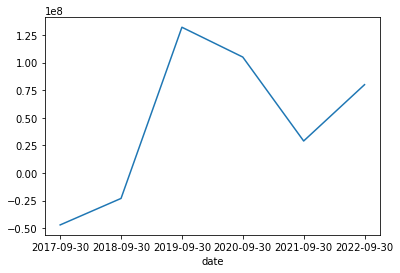

In [23]:
df_dna=comp_dna.sort_values("date")
df_dna.value.diff().diff().dropna().plot.line()

In [24]:
dna_sarima, summary_dna=build_sarima(df_dna)
summary_dna

Calculating a simple moving average model as sample time series data is too short.


C:\Users\Test\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Test\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency A-SEP w

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                    6
Model:                     ARMA(0, 1)   Log Likelihood                -117.836
Method:                       css-mle   S.D. of innovations       69613801.558
Date:                Sun, 19 Feb 2023   AIC                            241.673
Time:                        16:13:07   BIC                            241.048
Sample:                    09-30-2015   HQIC                           239.172
                         - 09-30-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.152e+08   5.38e+07     11.439      0.000     5.1e+08    7.21e+08
ma.L1.value     0.9997      0.772      1.295      0.195      -0.513       2.512
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0003           +0.0000j            1.0003            0.5000
-----------------------------------------------------------------------------
"""

In [25]:
def make_qqplot(df):
    m = df.value.mean()
    st = df.value.std()

    # Standardize the data
    df_norm=df.copy()
    for i in range(0,df.shape[0],1):
        df_norm.value.iloc[i]=(df.value.iloc[i]-m)/st

    value_min=int(df_norm['value'].min())
    value_max=int(df_norm['value'].max())
    q=[]
    j=0
    for i in range(1,df_norm.shape[0]+1,1):
        j=i/df_norm.shape[0]
        q_temp = np.quantile(df_norm['value'], j)
        q.append(q_temp)
    #fig, ax = plt.subplots(figsize=(7,5))
    plt.plot(q,sorted(df_norm.value),'o')
    plt.plot(list(range(value_min,value_max)), list(range(value_min,value_max)), color='red')
    plt.xlabel("Theoretical Quantile of standard normal distribution")
    plt.ylabel("Sample Z-score / Quantiles")
    plt.title("Normal Q-Q Plot")
    plt.grid()

In [26]:
def diagnostic_plt(sarima_model, df):
    if df.shape[0]<10:
        # see arima.py: if the time series length is too short, I am buildin a simple moving average model with ARMA that has a different syntax for the residuals.
        resid=pd.DataFrame(sarima_model.resid, columns=['value'])
    else:
        # make model residuals to dataframe
        resid=pd.DataFrame(sarima_model.resid(), columns=['value'])
    try:
        sarima_model.plot_diagnostics(figsize=(7,5))
        plt.show()
    except AttributeError as a:
        print(f'The following exception has occurred:\n{a}\n==> I will make individual diagnostic plots.')
        import seaborn as sns
        plt.rcParams.update({'figure.figsize':(7,5)})
        # Q-Q Plot
        plt.subplot(1, 2, 1) # row 1, col 2 index 1
        fig=make_qqplot(resid)
        # seaborn histogram
        plt.subplot(1, 2, 2) # row 1, col 2 index 1
        sns.distplot(resid, hist=True, kde=True, bins=3, color = 'blue', hist_kws={'edgecolor':'black'})
        #plt.legend(prop={'size': 16}, title = 'Method')
        plt.title('Histogram plus estimated density')
        plt.ylabel('Density')
        plt.show()
    except ValueError as e:
        print(f'The following exception has occurred:\n{e}\n==> I will make individual diagnostic plots.')
        import seaborn as sns
        plt.rcParams.update({'figure.figsize':(7,5)})
        # Q-Q Plot
        plt.subplot(1, 2, 1) # row 1, col 2 index 1
        fig=make_qqplot(resid)
        # seaborn histogram
        plt.subplot(1, 2, 2) # row 1, col 2 index 1
        sns.distplot(resid, hist=True, kde=True, bins=3, color = 'blue', hist_kws={'edgecolor':'black'})
        #plt.legend(prop={'size': 16}, title = 'Method')
        plt.title('Histogram plus estimated density')
        plt.ylabel('Density')
        plt.show()

The following exception has occurred:
'ARMAResults' object has no attribute 'plot_diagnostics'
==> I will make individual diagnostic plots.


C:\Users\Test\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


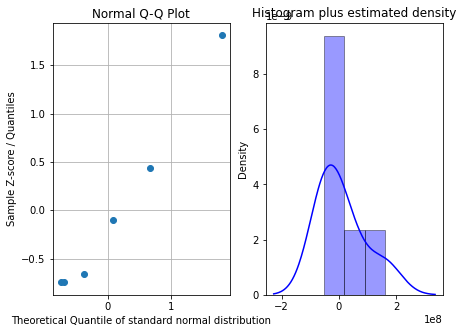

In [27]:
diagnostic_plt(dna_sarima, df_dna)

In [28]:
# dna_forecast_series=sarima_forecast(dna_sarima, df_dna, num_periods=6, company=company)
# dna_fc_list=dna_forecast_series.tolist()
# dna_fc_list

In [29]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
n_periods=6
df_date=df_dna.reset_index()
date_list=df_date['date'].values.tolist()
datetime_object = datetime.strptime(date_list[-1], '%Y-%m-%d')
new_dates=[]
for i in range(1, n_periods+1):
    #new_date=datetime_object+ relativedelta(years = i)
    new_dates.append(i)#.strftime("%Y")))
index_of_fc = new_dates #pd.DatetimeIndex(new_dates)
if df_dna.shape[0]<10:
    #fc_series=pd.Series(index=index_of_fc)
    fc_df=pd.DataFrame(dna_sarima.predict(start=1, end=n_periods))#, index=df_dna['date'].values)
    fc_df.set_index(index_of_fc, inplace=True)
    fc_series=fc_df.squeeze()
    # calculate confidence interval values manually and get it into a 2D array
    standard_error = st.sem(fc_series) # sample standard error
    bigl=[]
    for i in fc_series.tolist():
        l=[]
        # To find critical values for the t-distribution (in cases where n<30, we should not assume normality, hence go with the t-dist instead of the norm-dist and z-scores!)
        # we can use scipy: https://stackoverflow.com/questions/67340028/how-to-use-t-ppf-which-are-the-arguments
        # and https://www.geeksforgeeks.org/how-to-find-the-t-critical-value-in-python/
        # Explanation of PPF: Probability Point Function
        # The Probability Point Function or PPF is the inverse of the CDF. 
        # Specifically, the PPF returns the exact point where the probability of everything to the left is equal to y. 
        # This can be thought of as the percentile function since the PPF tells us the value of a given percentile of the data.
        t_critical_val=st.t.ppf(q=(1-.05)/2,df=n_periods-1) # assuming 95% CI, two-tailed test
        lvalue=i-(t_critical_val*standard_error)
        uvalue=i+(t_critical_val*standard_error)
        l.append(lvalue)
        l.append(uvalue)
        bigl.append(l)
    confint=np.array(bigl)
else:
    # FORECAST
    fc, confint = dna_sarima.predict(n_periods=n_periods, return_conf_int=True)
    # make series for plotting purposes
    fc_series=pd.Series(fc, index=index_of_fc)
fc_series

KeyError: 'None of [1, 2, 3, 4, 5, 6] are in the columns'

In [ ]:
lower_series=pd.DataFrame(confint[:, 0], index=fc_df.index)
upper_series=pd.DataFrame(confint[:, 1], index=fc_df.index)
fc_df[0].to_numpy()

In [ ]:
df_dna['value'].to_numpy()

In [ ]:
fig, ax = plt.subplots()
ax.plot(date_list, df_dna['value'].to_numpy(), label='Actual Values', color='blue')
ax.plot(fc_df[0].to_numpy(), label='Forecast Values', color = 'darkgreen')
#plt.plot(df_dna)
#plt.plot(fc_df, color='darkgreen')
plt.fill_between(fc_df.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)
plt.title(f'{company}: Final {n_periods}-year Forecast')
plt.xticks(rotation=90)
plt.show()

<b>CAPEX</b>

In [ ]:
df_cex=comp_cex.sort_values("date")
df_cex.value.diff().diff().dropna().plot.line()

In [ ]:
capex_sarima, summary_cex=build_sarima(df_cex)
summary_cex

In [ ]:
diagnostic_plt(capex_sarima, df_cex)

In [ ]:
capex_forecast_series=sarima_forecast(capex_sarima, df_cex, num_periods=6, company=company)
capex_fc_list=capex_forecast_series.tolist()
capex_fc_list

<b>Change in Working Capital (CWC)</b>

In [ ]:
df_cwc=comp_cwc.sort_values("date")
df_cwc.value.diff().diff().dropna().plot.line()
df_cwc

In [ ]:
cwc_sarima, summary_cwc=build_sarima(df_cwc)
diagnostic_plt(cwc_sarima)

In [ ]:
cwc_forecast_series=sarima_forecast(cwc_sarima, df_cwc, num_periods=6, company=company)
cwc_fc_list

---

In [ ]:
#=== NET DEBT
mask_nd=bs_y['item'].values=='netDebt'
net_debt=round(float(bs_y.loc[mask_nd, 'value'])/1000,0)
#=== CASH
mask_cash=bs_y['item'].values=='cashAndShortTermInvestments'
cash=round(float(bs_y.loc[mask_cash, 'value'])/1000, 0)

#### Calculation Method

We calculate the unlevered FCF as follows. Please find the picture below:

![dcf](assets/dcf.png)

The terminal value is calculate $uFCF_T*(1+g)/(WACC-g)$, where $g$ is the long-term growth rate (perpetual growth rate) and $uFCF_T$ is the last period uFCF.

In [ ]:
# Long-term growth rate, g
g=(wacc-0.025)
# Now, make forecast list for UNLEVERED FREE CASHFLOW through which the random variables as defined above, 
# i.e. the variables and their items which calculate unlevered free cashflow, will flow
def forecast_ufcf(last_rev, rev_cagr, margin_mean, tax, dna_fc_list, capex_fc_list, cwc_fc_list, wacc, g):
    forecast_lst=[]
    for i in range(len(dna_fc_list)):
        if i < len(dna_fc_list):
            ufcf_t=round(float(((last_rev*(1+rev_cagr)**(i+1))*margin_mean)*(1-tax)+dna_fc_list[i]+capex_fc_list[i]-cwc_fc_list[i])/1000,0)
            forecast_lst.append(ufcf_t)
        else :
            tv=round(float(((((last_rev*(1+rev_cagr)**(i))*margin_mean)*(1-tax)+dna_fc_list[i]+capex_fc_list[i]-cwc_fc_list[i])*(1+g))/(wacc-g))/1000,0)
            forecast_lst.append(tv)
    return forecast_lst

In [ ]:
forecast=forecast_ufcf(end_val, rev_cagr, oir_mean, tax, dna_fc_list, capex_fc_list, cwc_fc_list, wacc, g)
forecast

In [ ]:
# Now calculate the Present Value of the Free Cash Flows and the terminal value
# Function to discount the free cash flows and the terminal value
# I changed the function a bit as compared to https://towardsdatascience.com/company-valuation-using-probabilistic-models-with-python-712e325964b7
# because I calculated the terminal value already before in the forecast list!
def discount(forecast, wacc):
    discount_lst = []
    for x,i in enumerate(forecast):
        if x < 5:
            discount_lst.append(i/(1+wacc)**(x+1))
        else:
            discount_lst.append(i*(1/(1+wacc)**5))
    return sum(discount_lst)
intrinsic_value=round(float(discount(forecast, wacc)+cash-net_debt),0)
intrinsic_value

### Run Monte Carlo Simulation

In [ ]:
'''----// Run simulation: Monte Carlo //----'''
iterations=1000
hist_lst = []
# the rolling averages remain  the same; just change the input parameters like cagrs, operating margin mean, wacc and g (long-term growth)
for i in range(iterations):
    cagr = np.random.normal(rev_cagr, 0.01)
    margin = np.random.normal(oir_mean, 0.005)
    long_term_rate = np.random.normal(g, 0.001)
    discount_rate = np.random.normal(wacc, 0.001)
    forecast = forecast_ufcf(end_val, cagr, margin, tax, dna_fc_list, capex_fc_list, cwc_fc_list, discount_rate, long_term_rate)
    hist_lst.append(round(float(discount(forecast, discount_rate)+cash-net_debt),0))
hist_array = np.array(hist_lst)

In [ ]:
mean = hist_array.mean() # mean of the sampled point estimates
standard_error = hist_array.std()/(iterations**(1/2)) # sample standard error

lower_bound = mean-1.96*standard_error
upper_bound = mean+1.96*standard_error

In [ ]:
plt.hist(hist_array, bins=50, align='mid', color = 'steelblue', edgecolor='black')
plt.title('Sample Distribution ' + company);
plt.xlabel('Intrinsic Enterprise Value in €bn');
plt.ylabel('Frequency');
plt.savefig('assets/mc_sample.png', bbox_inches='tight')
plt.show()

In [ ]:
outstanding_shares=get_profile_data(ticker, json_entry='outstandingShares', entry_point='shares')
current_share_price=get_profile_data(ticker, json_entry='price', entry_point='profile')
intrinsic_share_price=round(intrinsic_value/outstanding_shares,2)

In [ ]:
if current_share_price > intrinsic_share_price:
    print(f'The company {company} seems to be overrated on the market. The market price exceeds the estimated intrinsic equity price per share:\n--------------------------\nMarket Price: {current_share_price}\nIntrinsic Share Price: {intrinsic_share_price}\n--------------------------')
else:
    print(f'The company {company} seems to be underrated on the market. The market price is below the estimated intrinsic equity price per share:\n--------------------------\nMarket Price: {current_share_price}\nIntrinsic Share Price: {intrinsic_share_price}\n--------------------------')